In [1]:
import pandas as pd
import numpy as np
import pathlib
import datetime
from datetime import datetime, timedelta, date
from rich import print
from collections import namedtuple
from dataclasses import dataclass, asdict
import operator

import tomllib
import tomlkit as tml
import json
import xarray as xr
import csvb.ingest as ci
import plotly.express as px
import plotly.graph_objects as go
from collections import namedtuple
#from decimal import Decimal, getcontext

#getcontext().prec = 2
pd.options.mode.copy_on_write = True
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
Transaction = namedtuple("Transaction", ["Date", "Amount", "From", "To", "Description", "Notes"], defaults=[""])

In [3]:
HOME = pathlib.Path.home()
cfgpth = HOME / ".config" / "csvb" / "config.toml"
with open(cfgpth, 'rb') as f:
    cfg = tomllib.load(f)
RULESPTH = HOME / cfg["paths"]["rules"]
BANKPTH = HOME / cfg["paths"]["bank"]
PRODUCTSPTH = HOME / cfg["paths"]["products"]
ACCT_NAMES = ["Type", "Account", "Subaccount"]
INST_ACCOUNTS = ["Assets:1st Source:Checking",
                 "Assets:Fidelity:HSA",
                 "Assets:Ally:Savins",
                 "Liabilities:NDFCU:Credit Card",
                 "Liabilities:Apple:Credit Card",
                 "Liabilities:Apple:Installments"]

In [4]:
fd  = ci.find_bank_files(HOME / pathlib.Path(cfg["paths"]["bank"])) 

In [5]:
try:
    del apl
except NameError:
    pass
apl = ci.ingest_bank_files(fd["Liabilities:Apple:Credit Card"]["files"],
                           fd["Liabilities:Apple:Credit Card"],
                           RULESPTH)

apl = ci.read_and_apply(apl, RULESPTH / fd["Liabilities:Apple:Credit Card"]["rules_file"])
apl[apl["From"] == ""]
#np.max(apl["Transaction Date"])

Empty DataFrame
Columns: [Transaction Date, Clearing Date, Description, Merchant, Category, Type, Amount (USD), Purchased By, Amount, From]
Index: []

In [6]:
try:
    del apl_inc
except NameError:
    pass
apl_inc = ci.ingest_bank_files(fd["Liabilities:Apple:Installments"]["files"],
                           fd["Liabilities:Apple:Installments"],
                           RULESPTH)

apl_inc[apl_inc["From"] == ""]
apl_inc

Date                                        Description    Amount  \
0 2022-05-20  iPhone - Apple Store MISHAWAKA IN TRANSACTION ... -1,299.00   
1 2022-05-20  iPhone AppleCare - Apple Store MISHAWAKA IN TR...   -199.00   
2 2024-02-09  Mac Pro M3 - Apple Online Store Cupertino CA T... -1,369.00   
3 2024-02-09  Mac Pro M3 AppleCare - Apple Online Store Cupe...   -279.00   

                   From  
0  Expenses:Electronics  
1  Expenses:Electronics  
2  Expenses:Electronics  
3  Expenses:Electronics

In [7]:
try:
    del fst
except NameError:
    pass
fst = ci.ingest_bank_files(fd["Assets:1st Source:Checking"]["files"],
                           fd["Assets:1st Source:Checking"],
                           RULESPTH)

fst = ci.read_and_apply(fst, RULESPTH / fd["Assets:1st Source:Checking"]["rules_file"])

fst[fst["From"] == ""]
#fst["Date"].max()

Empty DataFrame
Columns: [Transaction Number, Date, Description, Memo, Amount Debit, Amount Credit, Balance, Amount, From, Check Number, Fees  ]
Index: []

In [8]:
try:
    del ally
except NameError:
    pass
ally = ci.ingest_bank_files(fd["Assets:Ally:Savings"]["files"],
                           fd["Assets:Ally:Savings"],
                           RULESPTH)

ally = ci.read_and_apply(ally, RULESPTH / fd["Assets:Ally:Savings"]["rules_file"])

ally[ally["From"] == ""]
#ally.sort_values("Date")
#fd["Assets:Ally:Savings"]

Empty DataFrame
Columns: [Date, Time, Amount, Type, Description, From]
Index: []

In [9]:
try:
    del ndfcu
except NameError:
    pass
ndfcu = ci.ingest_bank_files(fd["Liabilities:NDFCU:Credit Card"]["files"],
                           fd["Liabilities:NDFCU:Credit Card"],
                           RULESPTH)

ndfcu = ci.read_and_apply(ndfcu, RULESPTH / fd["Liabilities:NDFCU:Credit Card"]["rules_file"])

ndfcu["Description"] = ndfcu["Description"].fillna("")

ndfcu[ndfcu["From"] == ""]
ndfcu[pd.isnull(ndfcu["From"])]

Empty DataFrame
Columns: [Date, Note, Description, Amount, Balance, From]
Index: []

In [10]:
try:
    del hsa
except NameError:
    pass
hsa = ci.ingest_bank_files(fd["Assets:Fidelity:HSA"]["files"],
                           fd["Assets:Fidelity:HSA"],
                           RULESPTH)
hsa = hsa.rename(columns={"Run Date": "Date",
                          "Action": "Description",
                          "Description": "Note",
                          "Amount ($)": "Amount",
                          
                         }
                )

hsa = ci.read_and_apply(hsa, RULESPTH / fd["Assets:Fidelity:HSA"]["rules_file"])
hsa[hsa["From"] == ""]

Empty DataFrame
Columns: [Date, Description, Symbol, Note, Type, Quantity, Price ($), Commission ($), Fees ($), Accrued Interest ($), Amount, Cash Balance ($), Settlement Date, From]
Index: []

In [11]:
bank_tables = {"Assets:1st Source:Checking": fst,
               "Liabilities:Apple:Credit Card": apl.rename(columns={"Transaction Date": "Date"}),
              "Assets:Ally:Savings": ally,
              "Liabilities:NDFCU:Credit Card": ndfcu,
              "Liabilities:Apple:Installments": apl_inc,
              "Assets:Fidelity:HSA": hsa}


trans = ci.to_transactions(bank_tables)
trans = trans.sort_values("Date")

In [12]:
try:
    del bal_decl
except NameError:
    pass

bal_decl = pd.read_csv(HOME / pathlib.Path(cfg["paths"]["bank"]) / "balances.csv",
                  header=0,
                  parse_dates=["Date"])
bal_decl

Date                         Account  Statement Balance
0  2024-08-31  Liabilities:Apple:Installments            -824.02
1  2024-08-31   Liabilities:Apple:Credit Card          -3,424.48
2  2024-04-18             Assets:Ally:Savings          11,604.81
3  2024-03-18             Assets:Ally:Savings          10,965.45
4  2024-02-18             Assets:Ally:Savings          10,330.00
5  2024-04-30   Liabilities:NDFCU:Credit Card            -501.39
6  2024-03-31   Liabilities:NDFCU:Credit Card          -1,570.40
7  2024-02-29   Liabilities:NDFCU:Credit Card          -1,758.27
8  2024-01-31   Liabilities:NDFCU:Credit Card          -1,565.79
9  2024-01-31             Assets:Fidelity:HSA           3,956.09
10 2024-08-31             Assets:Fidelity:HSA           6,524.05
11 2024-01-30      Assets:1st Source:Checking           1,297.66
12 2024-08-29      Assets:1st Source:Checking             622.49
13 2024-07-30      Assets:1st Source:Checking           8,365.45
14 2024-01-18             Assets:Ally:Savings           9,694.18
15 2022-12-07             Assets:Ally:Savings               0.00
16 2023-12-31   Liabilities:NDFCU:Credit Card             -99.77
17 2024-08-31   Liabilities:NDFCU:Credit Card          -1,315.17
18 2023-12-31  Liabilities:Apple:Installments            -312.21
19 2023-12-31   Liabilities:Apple:Credit Card            -284.77
20 2023-12-31             Assets:Fidelity:HSA           3,939.33
21 2022-12-31             Assets:Fidelity:HSA               0.00
22 2023-12-31      Assets:1st Source:Checking           2,320.59
23 2023-12-18             Assets:Ally:Savings          10,058.08
24 2024-08-18             Assets:Ally:Savings           1,495.04
25 2023-11-30   Liabilities:NDFCU:Credit Card          -2,085.08
26 2023-11-30   Liabilities:NDFCU:Credit Card          -2,085.08
27 2023-11-30  Liabilities:Apple:Installments            -374.62
28 2023-11-30   Liabilities:Apple:Credit Card            -201.50
29 2023-11-18             Assets:Ally:Savings           9,425.23
30 2023-10-31   Liabilities:NDFCU:Credit Card          -2,492.89
31 2023-10-31  Liabilities:Apple:Installments            -437.03
32 2023-10-31   Liabilities:Apple:Credit Card            -151.48
33 2023-10-18             Assets:Ally:Savings           8,793.47
34 2023-09-30   Liabilities:NDFCU:Credit Card          -1,581.47
35 2023-08-31   Liabilities:NDFCU:Credit Card             -69.79
36 2023-07-31   Liabilities:NDFCU:Credit Card          -3,172.26
37 2023-06-30   Liabilities:NDFCU:Credit Card          -1,409.14
38 2023-05-31   Liabilities:NDFCU:Credit Card            -351.48
39 2023-04-30   Liabilities:NDFCU:Credit Card          -3,924.01
40 2023-03-31   Liabilities:NDFCU:Credit Card          -2,519.52
41 2023-02-28   Liabilities:NDFCU:Credit Card            -885.51
42 2023-01-31   Liabilities:NDFCU:Credit Card          -1,376.20
43 2022-12-31   Liabilities:NDFCU:Credit Card             -76.69
44 2022-01-01           Liabilities:Auto:Loan          -4,216.71
45 2021-12-31  Liabilities:Apple:Installments            -552.08
46 2021-12-31   Liabilities:Apple:Credit Card          -2,522.77
47 2021-12-31      Assets:1st Source:Checking           5,067.54
48 2021-12-31             Assets:Ally:Savings           8,028.68

In [13]:
trans = pd.concat([trans, ci.gen_init_balance_trans(bal_decl)], ignore_index=True).sort_values("Date")
#trans[trans["To"] == "Assets:Fidelity:HSA"]

In [14]:
try:
    del ledgers
except NameError:
    pass
    
#ledgers = create_ledgers(trans)
#ledgers = ci.trans_to_ledgers(trans, bal_decl=bal_decl)
#ledgers[ledgers["Account"] == "Assets:1st Source:Checking"]
#ledgers[ledgers["Transaction Pair"] == "Liabilities:Auto:Loan"]
fg = trans.groupby("From")
tg = trans.groupby("To")
fl = {}
for acct in fg.groups:
    fl[acct] = trans.loc[fg.groups[acct]][["Date", "Description", "To"]].rename(columns={"To": "Transaction Pair"})
                                                                                                       
    fl[acct]["Incoming Amount"] = - 1 * trans.loc[fg.groups[acct]]["Amount"]
    fl[acct]["Account String"] = [acct] * len(fl[acct])

tl = {}
for acct in tg.groups:
    tl[acct] = trans.loc[tg.groups[acct]][["Date", "Description", "From"]].rename(columns={"From": "Transaction Pair"})
                                                                                                       
    tl[acct]["Incoming Amount"] = trans.loc[tg.groups[acct]]["Amount"]
    tl[acct]["Account String"] = [acct] * len(tl[acct])

ledgers = pd.concat(list(tl.values()) + list(fl.values())).sort_values("Date", ignore_index=True)

# Split account string to tuples.
acct_tuples = ledgers["Account String"].apply(lambda t:ci.to_triple(t, fill="")).apply(pd.Series).rename(columns=dict(zip(range(3), ACCT_NAMES)))
ledgers = pd.concat([ledgers, acct_tuples], axis="columns")

# Calculate cumulative balance.
ledgers["Balance"] = ledgers.groupby("Account String")["Incoming Amount"].cumsum()
ledgers[ledgers["Account String"] == "Liabilities:Apple:Installments"]
#ledgers


Date                      Description  \
4    2021-12-31                  Initial Balance   
133  2022-01-31   MONTHLY INSTALLMENTS (9 OF 24)   
135  2022-01-31   MONTHLY INSTALLMENTS (9 OF 24)   
250  2022-02-28  MONTHLY INSTALLMENTS (10 OF 24)   
251  2022-02-28  MONTHLY INSTALLMENTS (10 OF 24)   
...         ...                              ...   
5567 2024-06-30   MONTHLY INSTALLMENTS (5 OF 12)   
5756 2024-07-31   MONTHLY INSTALLMENTS (6 OF 12)   
5761 2024-07-31   MONTHLY INSTALLMENTS (6 OF 12)   
5934 2024-08-31   MONTHLY INSTALLMENTS (7 OF 12)   
5936 2024-08-31   MONTHLY INSTALLMENTS (7 OF 12)   

                   Transaction Pair  Incoming Amount  \
4            Equity:Initial Balance          -552.08   
133   Liabilities:Apple:Credit Card            28.29   
135   Liabilities:Apple:Credit Card             6.20   
250   Liabilities:Apple:Credit Card             6.20   
251   Liabilities:Apple:Credit Card            28.29   
...                             ...              ...   
5567  Liabilities:Apple:Credit Card            23.25   
5756  Liabilities:Apple:Credit Card           114.08   
5761  Liabilities:Apple:Credit Card            23.25   
5934  Liabilities:Apple:Credit Card            23.25   
5936  Liabilities:Apple:Credit Card           114.08   

                      Account String         Type Account    Subaccount  \
4     Liabilities:Apple:Installments  Liabilities   Apple  Installments   
133   Liabilities:Apple:Installments  Liabilities   Apple  Installments   
135   Liabilities:Apple:Installments  Liabilities   Apple  Installments   
250   Liabilities:Apple:Installments  Liabilities   Apple  Installments   
251   Liabilities:Apple:Installments  Liabilities   Apple  Installments   
...                              ...          ...     ...           ...   
5567  Liabilities:Apple:Installments  Liabilities   Apple  Installments   
5756  Liabilities:Apple:Installments  Liabilities   Apple  Installments   
5761  Liabilities:Apple:Installments  Liabilities   Apple  Installments   
5934  Liabilities:Apple:Installments  Liabilities   Apple  Installments   
5936  Liabilities:Apple:Installments  Liabilities   Apple  Installments   

       Balance  
4      -552.08  
133    -523.79  
135    -517.59  
250    -511.39  
251    -483.10  
...        ...  
5567 -1,375.47  
5756 -1,261.39  
5761 -1,238.14  
5934 -1,214.89  
5936 -1,100.81  

[75 rows x 9 columns]

# Ledger Table with Zeros

In [15]:
lw0 = ledgers
#lw0 = lw0.set_index("Date")
daily = pd.date_range(start=lw0["Date"].min(), end=lw0["Date"].max(), freq="1D")
def add_dates(df):
    datesnotin = daily[~daily.isin(df["Date"])]
    newdf = pd.DataFrame({"Date": datesnotin,
                          "Incoming Amount": [0.0] * len(datesnotin),
                          "Description": ["Fake Zero"] * len(datesnotin)
                         })
    newdf = pd.concat([df, newdf]).sort_values("Date")
    #print(newdf)
    cols=["Transaction Pair", "Account String", "Balance"]
    newdf.loc[:, cols]  = newdf.loc[:, cols].ffill()
    newdf.loc[:, ["Transaction Pair", "Account String"]] = newdf.loc[:, ["Transaction Pair", "Account String"]].bfill()
    #print(newdf)
    newdf["Balance"] = newdf["Balance"].fillna(0.0)
    return newdf
    
lw0 = lw0.groupby(ACCT_NAMES).apply(add_dates, include_groups=False)
lw0=lw0.reset_index().drop(columns="level_3").sort_values("Date")

In [16]:
#g = ledge_with_acct["Incoming Amount"].groupby(ledge_with_acct.index).sum("Incoming Amount")
# Select all lines with an initial balance.

clear_virtuals=True

start_date = None
end_date = None #date(2024,1,1)

ltable = ledgers

if start_date is not None:
    ltable = ltable[ltable["Date"] >= pd.Timestamp(start_date)]
if end_date is not None:
    ltable = ltable[ltable["Date"] <= pd.Timestamp(end_date)]


# Group on Accounts
acct_g = ltable.groupby(ACCT_NAMES)

# Choose first and last date of each group from ltable, reassign with column names and set account as multiindex.
start = acct_g.head(1)[["Date", "Balance"] + ACCT_NAMES].rename(columns={"Date": "Start Date", "Balance": "Initial Balance"}).set_index(ACCT_NAMES)
end = acct_g.tail(1)[["Date", "Balance"] + ACCT_NAMES].rename(columns={"Date": "End Date", "Balance": "End Balance"}).set_index(ACCT_NAMES)

#br = br.set_index(pd.MultiIndex.from_tuples(br.index.to_series().apply(ci.to_triple), names=["Type", "Account", "Subaccount"])a
br = pd.concat([start, end],axis="columns")
br["Difference"] = br["End Balance"] - br["Initial Balance"]
br
#acct_g["Date"].groups["Expenses:Reimbursible"]

Start Date  Initial Balance  \
Type        Account         Subaccount                                 
Assets      1st Source      Checking     2021-12-31         5,067.54   
Liabilities Apple           Credit Card  2021-12-31           -14.99   
                            Installments 2021-12-31          -552.08   
            NDFCU           Credit Card  2021-12-31           -86.95   
Equity      Initial Balance              2021-12-31         2,522.77   
...                                             ...              ...   
Expenses    Medical         Dentist      2023-05-26           114.00   
Income      Rewards                      2023-12-04           -25.50   
Expenses    Services                     2024-03-10            59.95   
            Recovery                     2024-03-13           255.94   
            Home            Major        2024-08-05         8,284.00   

                                           End Date  End Balance  Difference  
Type        Account         Subaccount                                        
Assets      1st Source      Checking     2024-08-30     6,183.68    1,116.14  
Liabilities Apple           Credit Card  2024-08-31    -3,010.36   -2,995.37  
                            Installments 2024-08-31    -1,100.81     -548.73  
            NDFCU           Credit Card  2024-08-31       420.47      507.42  
Equity      Initial Balance              2022-12-31    -5,727.97   -8,250.74  
...                                             ...          ...         ...  
Expenses    Medical         Dentist      2023-05-26       114.00        0.00  
Income      Rewards                      2024-08-01      -748.37     -722.87  
Expenses    Services                     2024-03-10        59.95        0.00  
            Recovery                     2024-03-13       255.94        0.00  
            Home            Major        2024-08-05     8,284.00        0.00  

[66 rows x 5 columns]

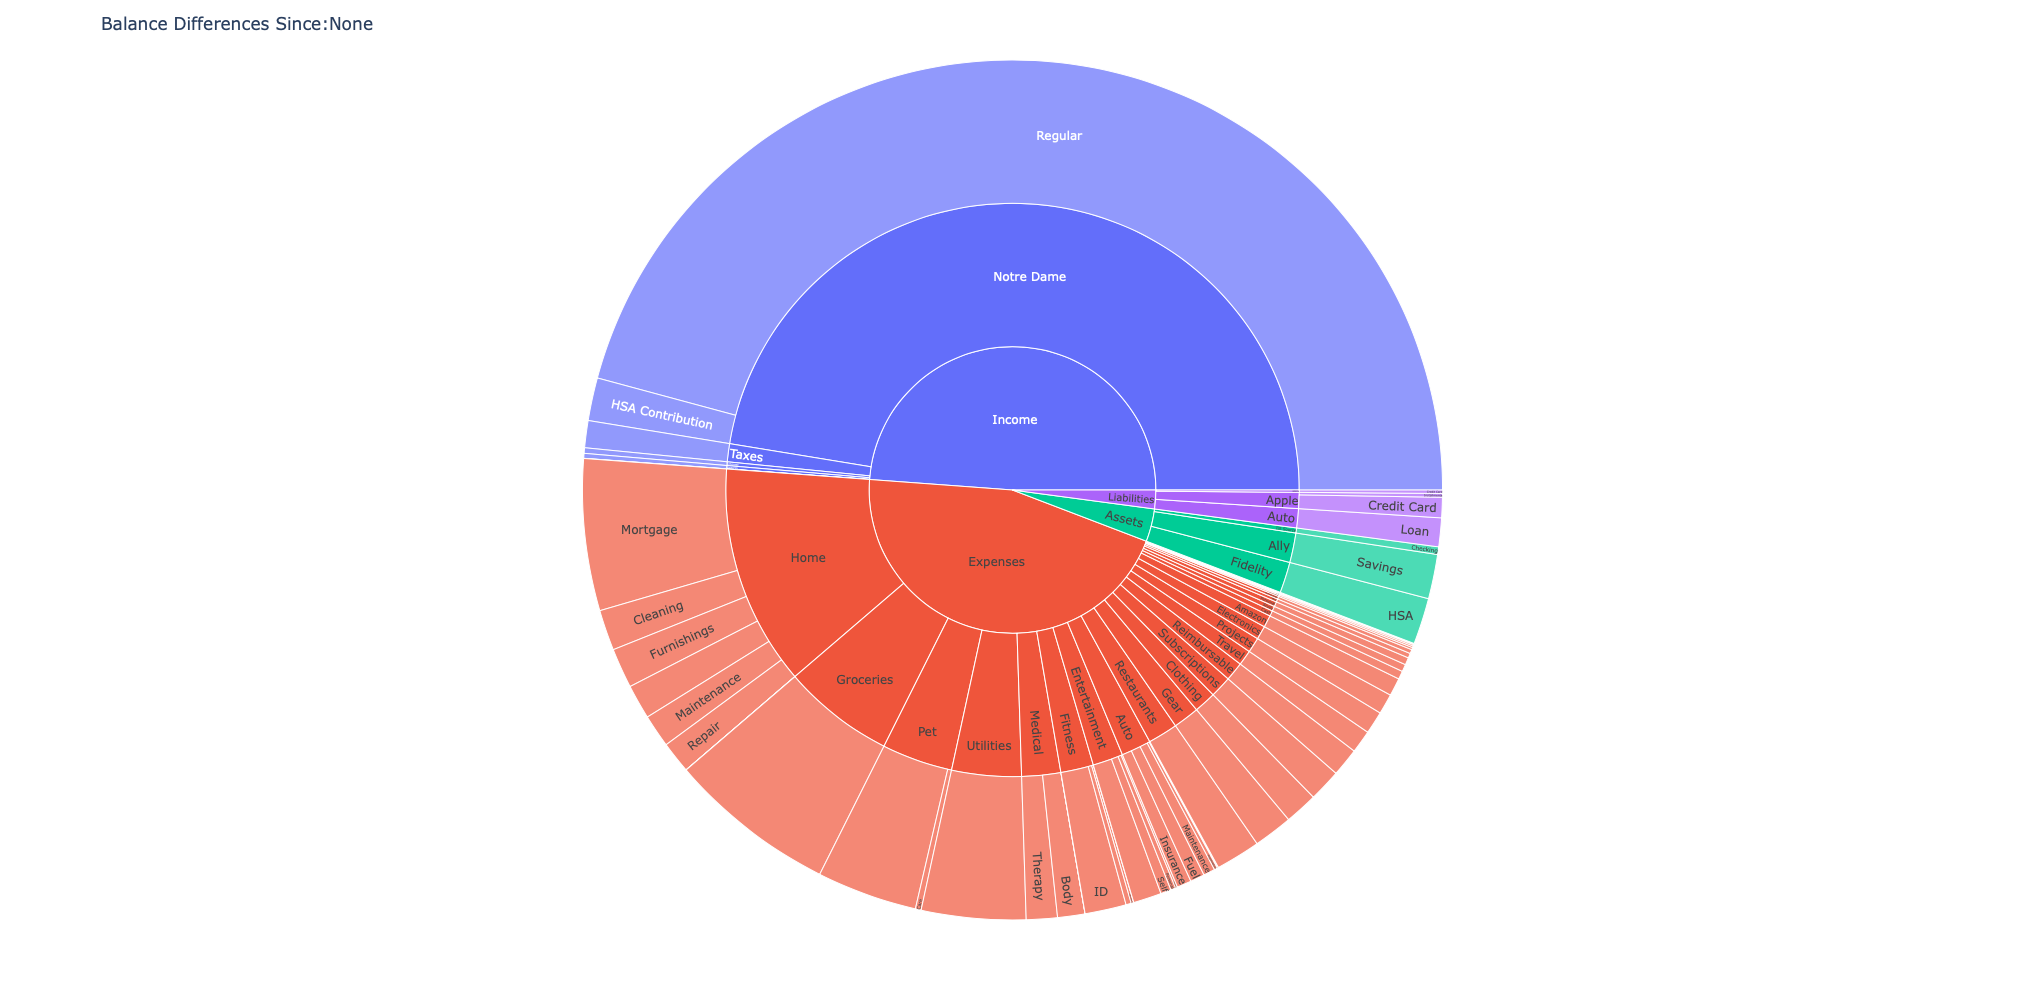

In [17]:
#cutoff_ledgers["Liabilities:Auto:Loan"].iloc[-2:-1]
#cb = ci.balances(ledgers)
#cb
df = br
df = pd.DataFrame({"Type": df.index.get_level_values("Type"),
                   "Account": df.index.get_level_values("Account"),
                   "Subaccount": df.index.get_level_values("Subaccount"),
                   "Difference": df["Difference"].apply(np.abs)})
df = df.loc[df["Type"] != "Transfer"]
df = df.loc[df["Type"] != "Equity"]
df = df.fillna("")
df = df.replace(np.inf,0)
#df = df.loc[
sbfig = px.sunburst(df, path=["Type", "Account", "Subaccount"], values="Difference")
sbfig.update_layout(height=1000, title=f"Balance Differences Since:{str(start_date)}")
sbfig.show()
#sbfig.data

In [18]:
#flow = trans.groupby(["From", "To"])
pt = trans.copy()
pt.loc[trans["Amount"] < 0, "To"] = trans.loc[trans["Amount"] < 0, "From"]
pt.loc[trans["Amount"] < 0, "From"] = trans.loc[trans["Amount"] < 0, "To"]
pt.loc[trans["Amount"] < 0, "Amount"] = -1 * trans.loc[trans["Amount"] < 0, "Amount"]
flow = pt.groupby(["From", "To"])
flow_df = pd.DataFrame(flow.Amount.aggregate("sum"))

In [19]:
accts = list(ci.accounts(flow_df.index.to_frame()))

labels = accts
sources = [accts.index(a) for a in flow_df.index.to_frame()["From"].values]
targets = [accts.index(a) for a in flow_df.index.to_frame()["To"].values]
values = flow_df["Amount"]

f = go.Figure(data=[go.Sankey(
    node = dict(
        pad=15,
        thickness = 5,
        line=dict(color = "black", width = 0.5),
        label = labels
    ),
    link = dict(
        source = sources,
        target = targets,
        value = values.values,
    )
)
                   ]
             )


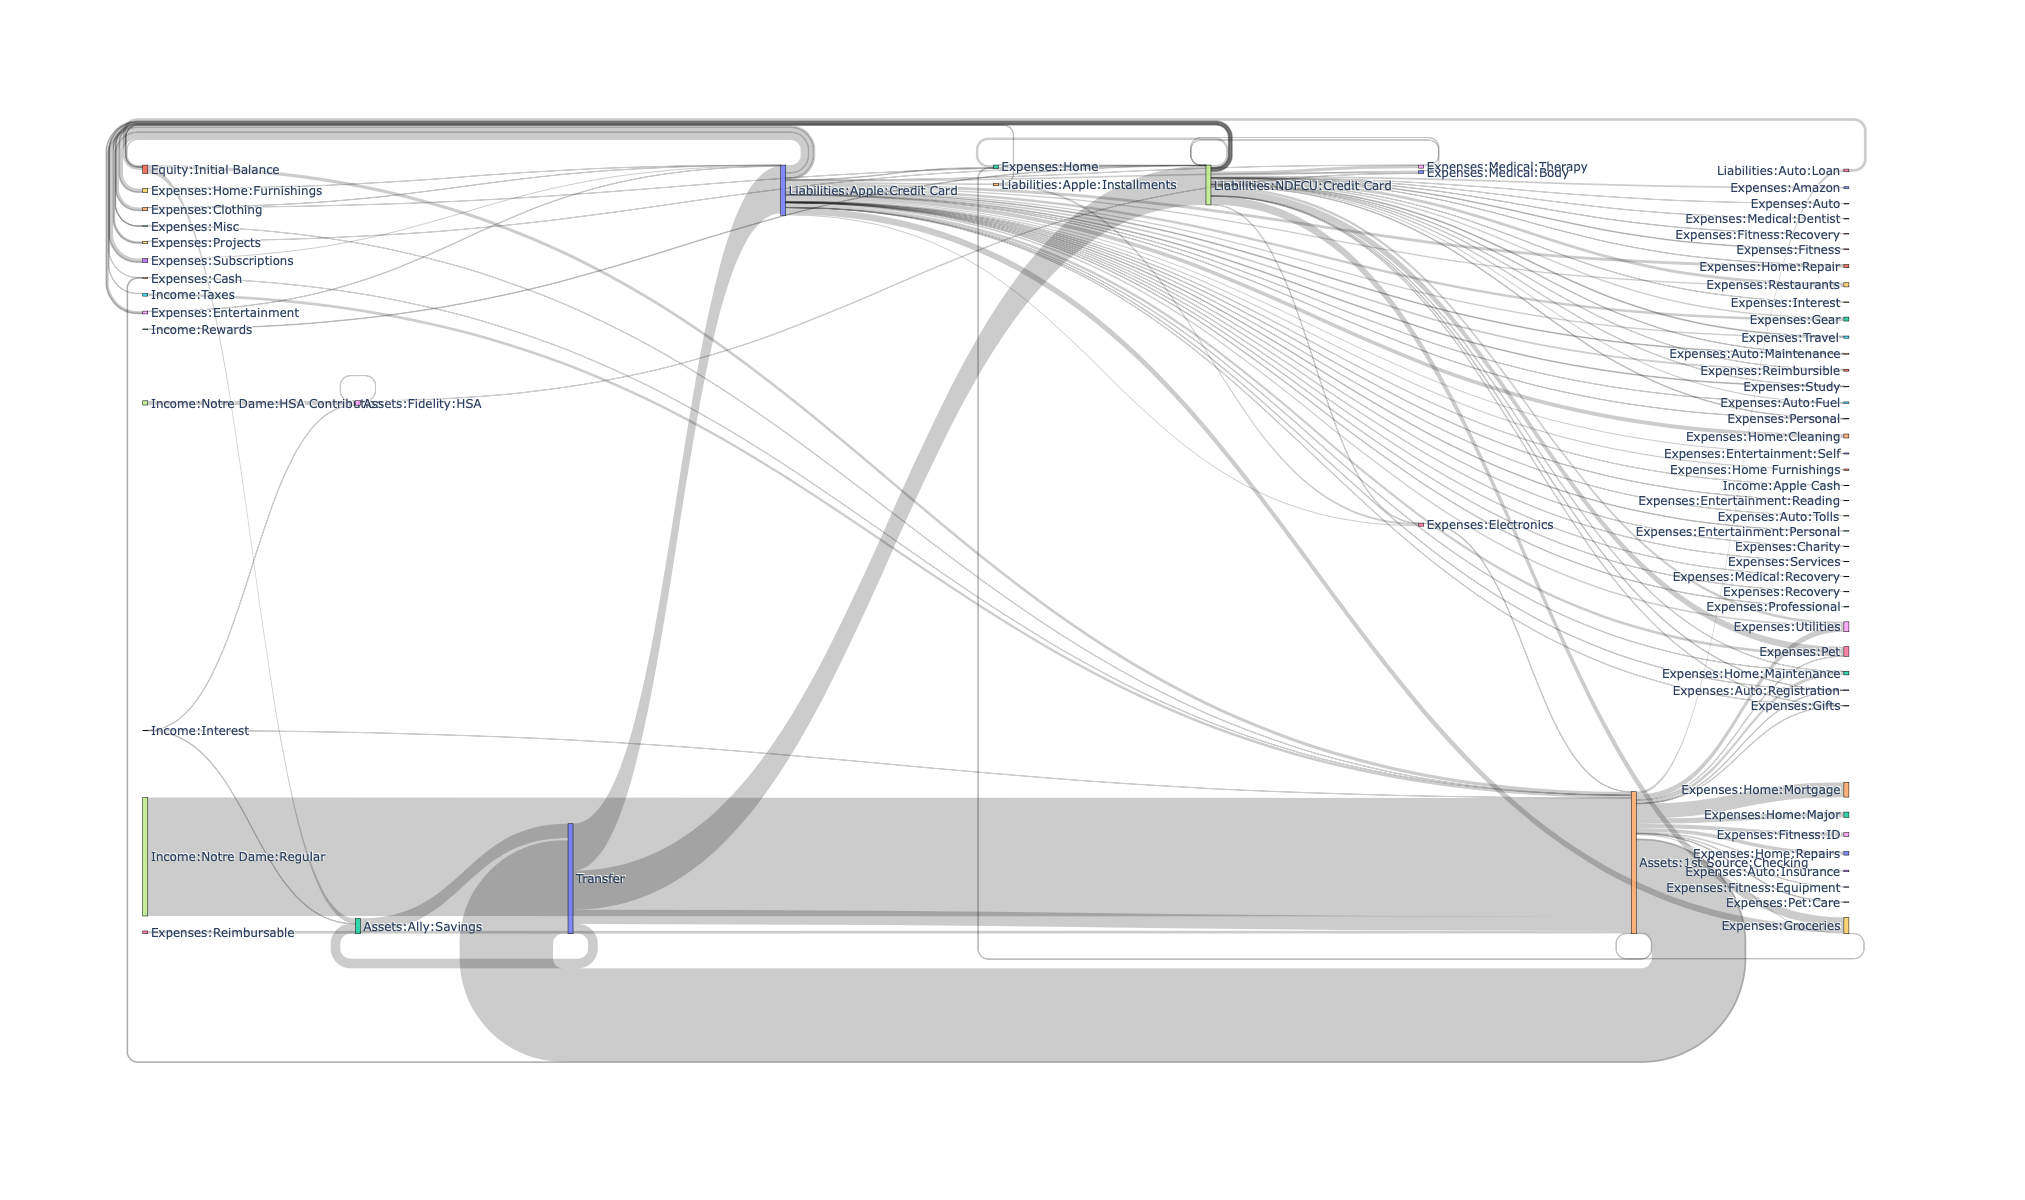

In [20]:
f.update_layout(height=1200)
f.show()

In [21]:
monthly_sum = lw0.groupby(ACCT_NAMES + ["Date"]).sum().groupby(ACCT_NAMES + [pd.Grouper(freq="ME", level=-1)])["Incoming Amount"].sum()
px.scatter(monthly_sum.loc[("Expenses", "Electronics", "")], y="Incoming Amount")

monthly_mean = monthly_sum.groupby(ACCT_NAMES).mean()

In [22]:
monthly_mean

Type         Account          Subaccount  
Assets       1st Source       Checking        181.87
             Ally             Savings          43.97
             Fidelity         HSA             200.62
Equity       Initial Balance                 -168.47
Expenses     Amazon                            77.89
                                               ...  
Liabilities  Apple            Credit Card     -88.54
                              Installments    -32.38
             Auto             Loan             -0.00
             NDFCU            Credit Card      12.37
Transfer                                     -107.02
Name: Incoming Amount, Length: 66, dtype: float64

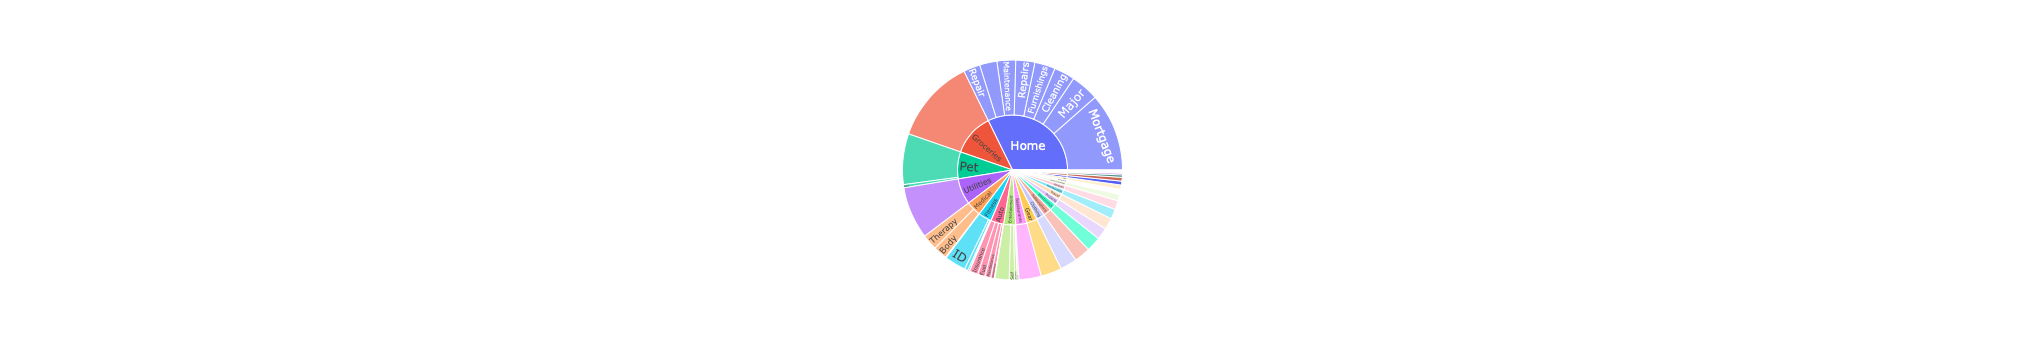

In [23]:
mean_expenses = monthly_mean["Expenses"]
remaining = mean_expenses.sum() + monthly_mean["Income"].sum()
monthly = pd.concat([mean_expenses, pd.Series(data=-1 * remaining, index=pd.MultiIndex.from_tuples([("Remaining", "", "")]))], axis="rows")
monthly.index.names=["Account", "Subaccount"]
monthly.name="Total"
px.sunburst(monthly.reset_index(), path=["Account", "Subaccount"], values="Total")

In [24]:
trans[trans.From == "Expenses:Utilities"]

Date                                        Description  Amount  \
17   2022-01-05  AMZN MKTP US*ET0DT6QC3   . AMZN.COM/BILL. WA 0000  -17.12   
25   2022-01-12                          VERIZON WIRELESS PAYMENTS -107.88   
33   2022-01-14  CITY OF SOUTH BEND       . 574-223-0311 . IN 0000  -88.80   
28   2022-01-14                          AEP INDIANA MICH BILL PAY -101.15   
37   2022-01-16  AMZN MKTP US*HU2BX13K3   . AMZN.COM/BILL. WA 0000  -85.96   
...         ...                                                ...     ...   
2904 2024-08-08  CITY OF SOUTH BEND 227 WEST JEFFERSON BLVD STE... -184.47   
2913 2024-08-09                          VERIZON WIRELESS PAYMENTS -114.64   
2916 2024-08-12                            NIPSCO ACCOUNTS BILLPAY  -22.80   
2920 2024-08-14                          AEP INDIANA MICH BILL PAY -118.04   
2926 2024-08-19  COMCAST CHICAGO          . 800-COMCAST  . IL 0000 -107.05   

                    From                             To  
17    Expenses:Utilities  Liabilities:NDFCU:Credit Card  
25    Expenses:Utilities     Assets:1st Source:Checking  
33    Expenses:Utilities  Liabilities:NDFCU:Credit Card  
28    Expenses:Utilities     Assets:1st Source:Checking  
37    Expenses:Utilities  Liabilities:NDFCU:Credit Card  
...                  ...                            ...  
2904  Expenses:Utilities  Liabilities:Apple:Credit Card  
2913  Expenses:Utilities     Assets:1st Source:Checking  
2916  Expenses:Utilities     Assets:1st Source:Checking  
2920  Expenses:Utilities     Assets:1st Source:Checking  
2926  Expenses:Utilities  Liabilities:NDFCU:Credit Card  

[191 rows x 5 columns]

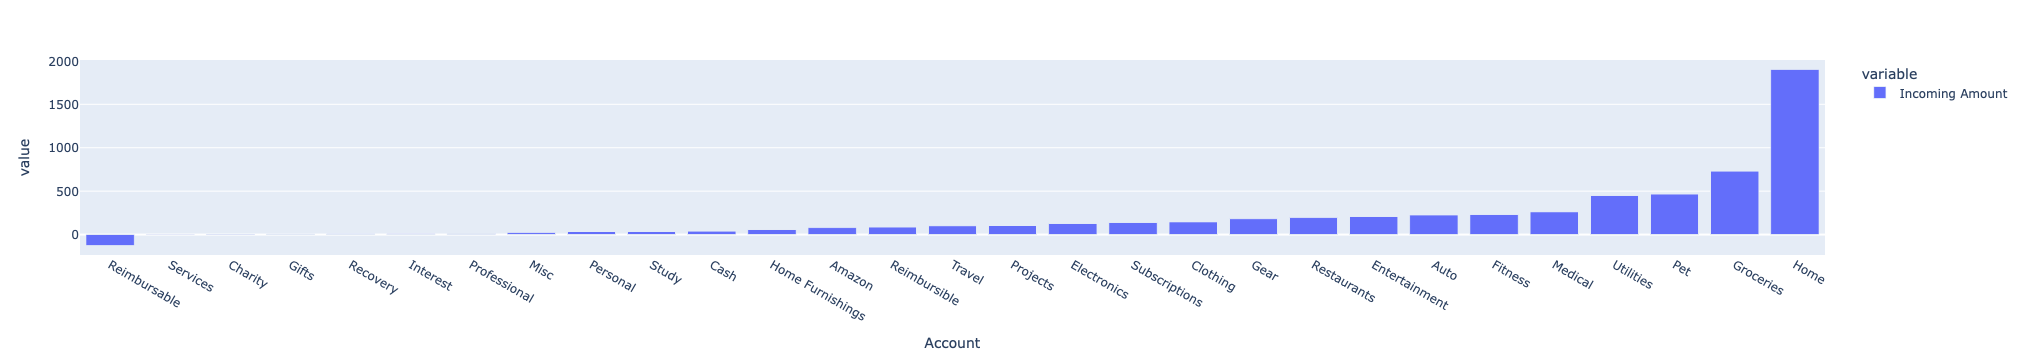

In [25]:
df = monthly_mean["Expenses"].groupby(["Account"]).sum().sort_values()
px.bar(df)

In [26]:
pmsum = monthly_sum["Expenses"]#.reset_index()
#pmsum["Acctstr"] = pmsum["Account"] + ":" + pmsum["Subaccount"]
#pmsum["Date"] = pmsum["Date"].astype(object).apply(pd.Period.to_timestamp)

In [27]:
pmsum=pmsum.reorder_levels(["Date", "Account", "Subaccount"])

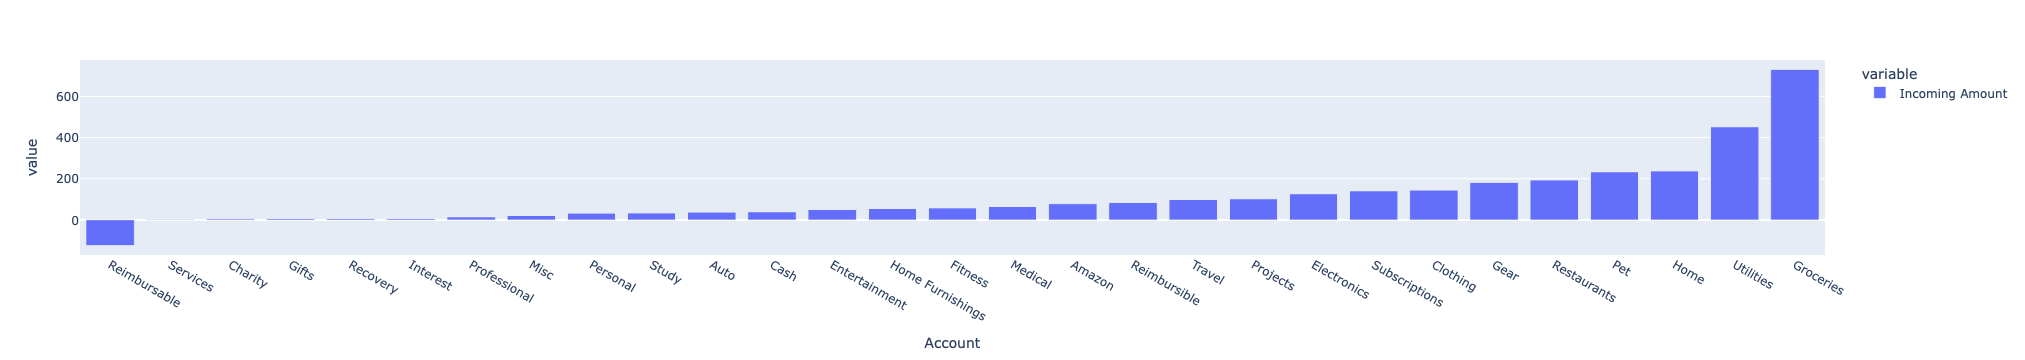

In [28]:
df = monthly_sum["Expenses"]
#px.bar(df.sort_values())
df = df.groupby("Account").mean()
px.bar(df.sort_values())

In [29]:
pdextension = pd.period_range(start = pmsum.index.levels[0][-1], end=pd.Period("2024-12"), freq="M")[1:]

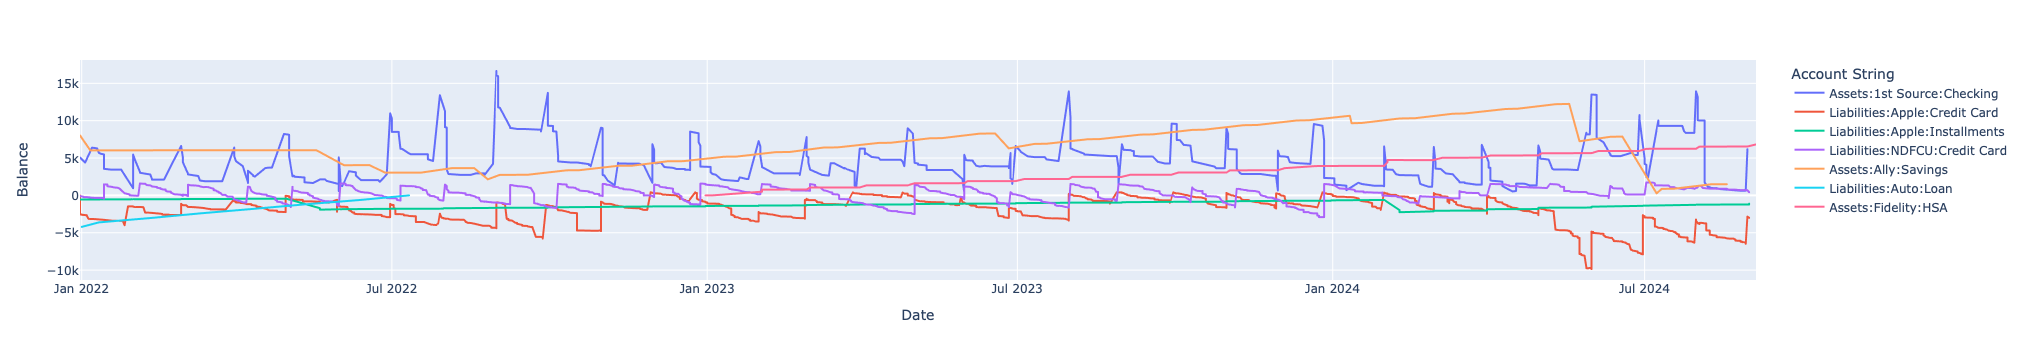

In [30]:
px.line(ledgers[ledgers["Type"].isin(["Assets", "Liabilities"])], x="Date", y="Balance", color="Account String")

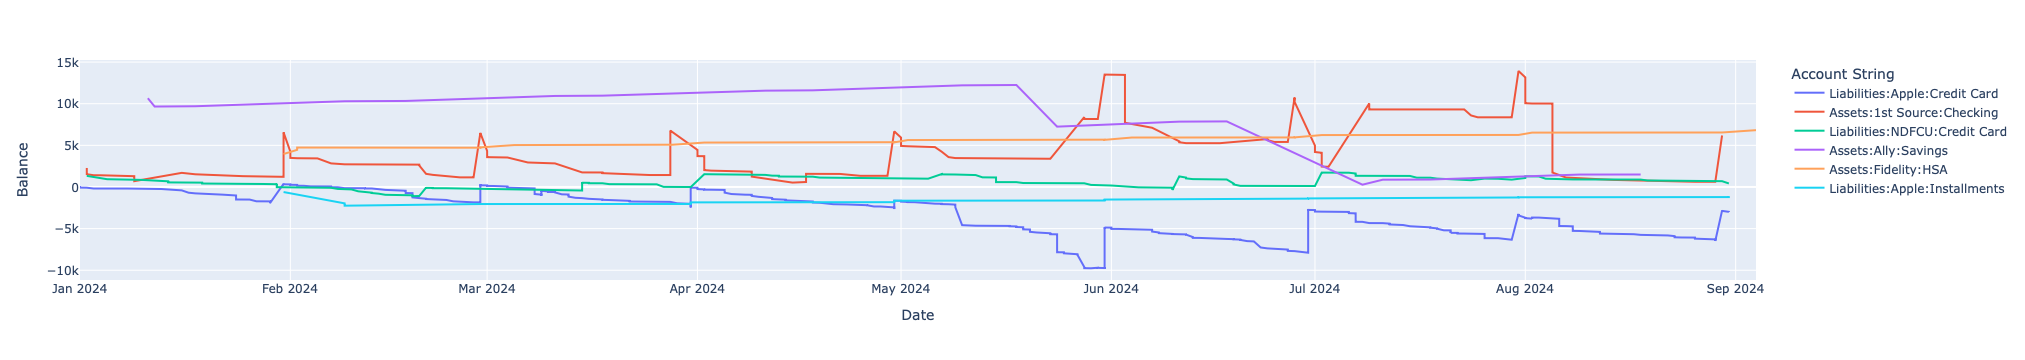

In [31]:
exp = ledgers[ledgers["Type"].isin(["Assets", "Liabilities"])]
px.line(exp[exp["Date"] >= pd.Timestamp(2024, 1, 1)], x="Date", y="Balance", color="Account String")

In [32]:
budget = {}
for idx in pdextension:
    budget[idx] = monthly_mean
budget = pd.DataFrame(budget)

In [33]:
btrans = pd.DataFrame(budget.T.stack(["Account", "Subaccount"])).rename(columns={0:"Amount"})
#help(btrans.index)
#btrans["Account String"] = [":".join(("Expenses", a, b)) for a, b in zip(btrans.index.get_level_values("Account"),
#                                                           btrans.index.get_level_values("Subaccount"))]
#btrans=btrans.droplevel("Account")
#btrans=btrans.droplevel("Subaccount")

#def stripcolon(s):
#    if s.endswith(":"):
#        return s[:-1]
#    else:
#        return s
#btrans["To"] = btrans["Account String"].apply(stripcolon)

/var/folders/_k/gn10qdmd1_n3s4xndw8d3nvc0000gp/T/ipykernel_55904/1351139105.py:1: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.



In [34]:
endassets = br.loc["Assets"]["End Balance"]
endliabilities = br.loc["Liabilities"]["End Balance"]

In [35]:
start = pd.DataFrame(pd.concat([endassets, endliabilities])).rename(columns={"End Balance": "Balance"})

In [36]:
start["Description"] = "Ending Balance"

In [37]:
expsum = btrans.groupby(level=0).sum()
#expsum["Balance"] = expsum.cumsum()

In [38]:
expsum

Type     Assets  Equity  Expenses    Income  Liabilities  Transfer
2024-10  426.47 -168.47  5,715.15 -5,757.59      -108.55   -107.02
2024-11  426.47 -168.47  5,715.15 -5,757.59      -108.55   -107.02
2024-12  426.47 -168.47  5,715.15 -5,757.59      -108.55   -107.02

In [39]:
dfs = {}
keep = ["Date", "Description", "Account String"]
accts = []
for typ in ["Assets", "Liabilities", "Transfer"]:
    accts.append(pd.unique(ledgers[ledgers["Type"] == typ]["Account String"]))
accts = np.concatenate(accts)

bals = []
grouped = ledgers.groupby("Account String")
for acct in accts:
    bals.append(grouped.get_group(acct)["Balance"].rename("Balance " + acct))

balance_table=pd.concat([ledgers[keep], pd.concat(bals, axis="columns")], join="inner", axis="columns").sort_values("Date").ffill().fillna(0)

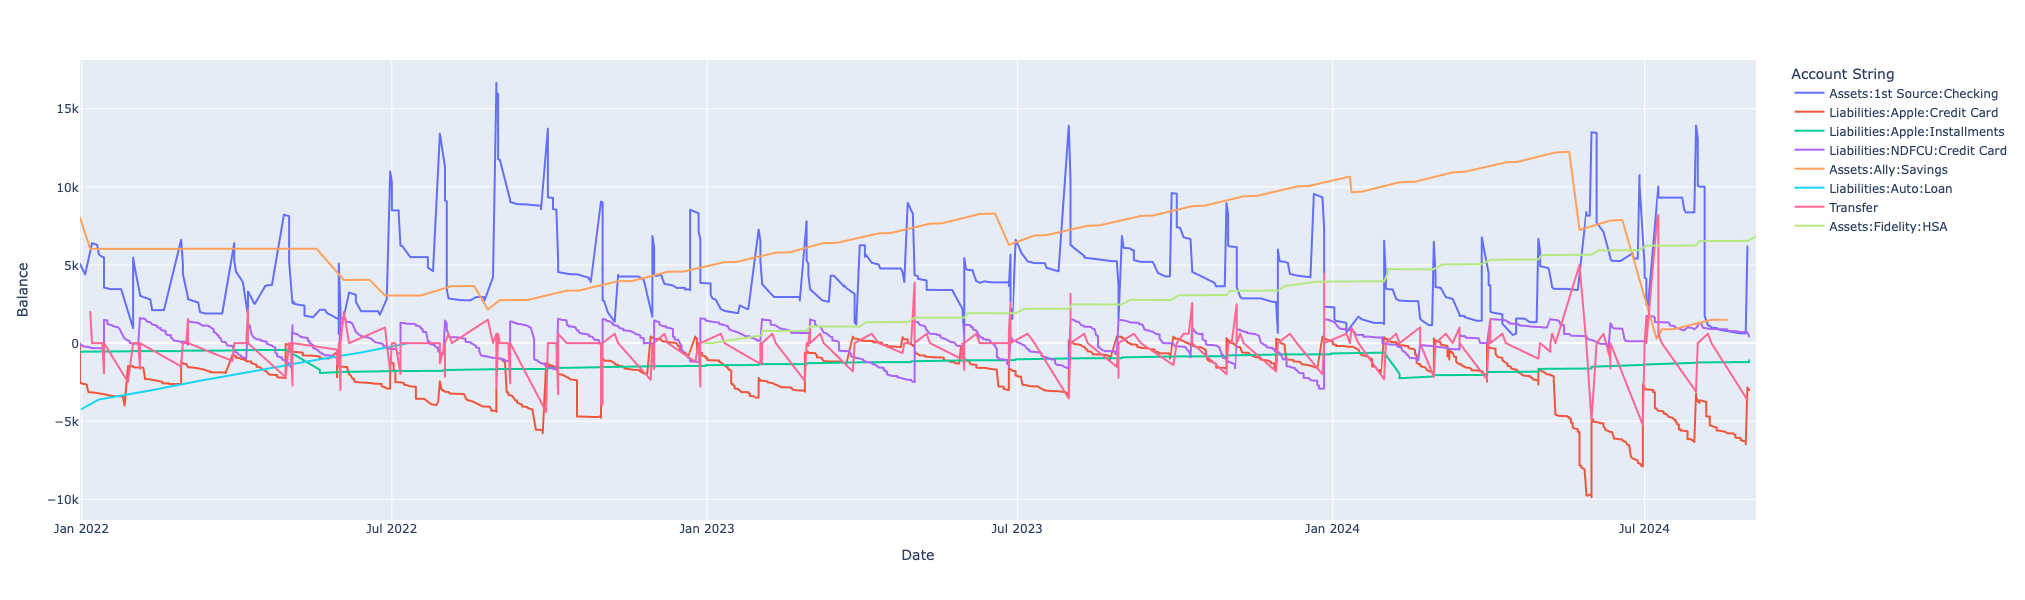

In [40]:
px.line(ledgers[ledgers["Type"].isin(["Assets", "Liabilities", "Transfer"])].set_index("Date"),
        y="Balance", color="Account String", height=600)

In [41]:
pd.set_option('display.max_rows', 100, 'display.max_columns', None)

In [42]:
asgrouped = ledgers.groupby("Account String")["Incoming Amount"].sum()
asgrouped.name="Asset String"
tpgrouped = ledgers.groupby("Transaction Pair")["Incoming Amount"].sum()
tpgrouped.name="Transaction Pair"

In [43]:
pd.options.display.float_format = '{:,.2f}'.format


check = pd.concat([asgrouped,-1 *  tpgrouped], axis="columns")#.rename(columns={"Incoming Amount"Asset String", 1:"Transaction Pair"})

In [44]:
check[check["Asset String"] != check["Transaction Pair"]].assign(Diff=check["Asset String"] - check["Transaction Pair"])

Asset String  Transaction Pair  Diff
Assets:1st Source:Checking         6,183.68          6,183.68 -0.00
Liabilities:Apple:Credit Card     -3,010.36         -3,010.36 -0.00

In [45]:
final_balance = ledgers.groupby(ACCT_NAMES)["Incoming Amount"].sum()

In [46]:
monthly_incoming = lw0.set_index(["Date"]).sort_index().groupby(ACCT_NAMES).resample("ME")["Incoming Amount"].sum()

In [47]:
this_year_inc = monthly_incoming.loc[(slice(None), slice(None), slice(None), slice(pd.Timestamp("2023-12-31"), pd.Timestamp("2024-05-31")))]

In [48]:
end_of_2023_bals = lw0.set_index(["Date"]).sort_index()[:pd.Timestamp("2023-12-31")].groupby(ACCT_NAMES)["Incoming Amount"].sum()

In [49]:
meaningful_eo23_bals = end_of_2023_bals.loc[["Assets", "Liabilities", "Transfer"]]

In [50]:
meaningful_eo23_bals

Type         Account     Subaccount  
Assets       1st Source  Checking        2,320.49
             Ally        Savings        10,058.08
             Fidelity    HSA             3,939.33
Liabilities  Apple       Credit Card       129.35
                         Installments     -663.92
             Auto        Loan               -0.00
             NDFCU       Credit Card     1,431.08
Transfer                                     0.00
Name: Incoming Amount, dtype: float64

In [51]:
budget.loc[["Income"]]

2024-10   2024-11   2024-12
Type   Account    Subaccount                                    
Income Apple Cash                       0.77      0.77      0.77
       Interest                       -24.07    -24.07    -24.07
       Notre Dame HSA Contribution   -193.62   -193.62   -193.62
                  Regular          -5,404.80 -5,404.80 -5,404.80
       Rewards                        -22.01    -22.01    -22.01
       Taxes                         -113.85   -113.85   -113.85

In [52]:
tot_exp_2024_to_date=this_year_inc["Expenses"].sum()
print(tot_exp_2024_to_date)

38030.05

In [53]:
tot_inc_2024_to_date=this_year_inc["Income"].sum()
print(-1*tot_inc_2024_to_date)

35578.689999999995

In [54]:
-1 * tot_inc_2024_to_date - tot_exp_2024_to_date

-2451.360000000008

In [55]:
meaningful_eo23_bals

Type         Account     Subaccount  
Assets       1st Source  Checking        2,320.49
             Ally        Savings        10,058.08
             Fidelity    HSA             3,939.33
Liabilities  Apple       Credit Card       129.35
                         Installments     -663.92
             Auto        Loan               -0.00
             NDFCU       Credit Card     1,431.08
Transfer                                     0.00
Name: Incoming Amount, dtype: float64

In [56]:
final_balance.loc[["Assets", "Liabilities", "Transfer"]]

Type         Account     Subaccount  
Assets       1st Source  Checking        6,183.68
             Ally        Savings         1,495.04
             Fidelity    HSA             6,821.21
Liabilities  Apple       Credit Card    -3,010.36
                         Installments   -1,100.81
             Auto        Loan               -0.00
             NDFCU       Credit Card       420.47
Transfer                                -3,638.57
Name: Incoming Amount, dtype: float64

In [57]:
final_balance.loc[["Assets", "Liabilities", "Transfer"]].sum() - meaningful_eo23_bals.sum()

-10043.750000000005

In [58]:
rem_income = budget.loc[[("Income", "Notre Dame", "Regular"), ("Income", "Apple Cash", "")]]
rem_income

2024-10   2024-11   2024-12
Type   Account    Subaccount                              
Income Notre Dame Regular    -5,404.80 -5,404.80 -5,404.80
       Apple Cash                 0.77      0.77      0.77

In [59]:
budget[pd.Period("2024-10")].loc[("Expenses", "Amazon")]

Subaccount
   77.89
Name: 2024-10, dtype: float64

In [60]:
budget

2024-10   2024-11   2024-12
Type        Account          Subaccount                                    
Assets      1st Source       Checking            181.87    181.87    181.87
            Ally             Savings              43.97     43.97     43.97
            Fidelity         HSA                 200.62    200.62    200.62
Equity      Initial Balance                     -168.47   -168.47   -168.47
Expenses    Amazon                                77.89     77.89     77.89
            Auto                                   0.28      0.28      0.28
                             Fuel                 62.82     62.82     62.82
                             Insurance            75.57     75.57     75.57
                             Maintenance          50.61     50.61     50.61
                             Registration         30.40     30.40     30.40
                             Tolls                 4.78      4.78      4.78
            Cash                                  38.49     38.49     38.49
            Charity                                4.68      4.68      4.68
            Clothing                             144.47    144.47    144.47
            Electronics                          126.09    126.09    126.09
            Entertainment                        122.44    122.44    122.44
                             Personal             22.59     22.59     22.59
                             Reading              13.67     13.67     13.67
                             Self                 47.56     47.56     47.56
            Fitness                               29.35     29.35     29.35
                             Equipment             2.94      2.94      2.94
                             ID                  185.29    185.29    185.29
                             Recovery             12.94     12.94     12.94
            Gear                                 180.45    180.45    180.45
            Gifts                                  6.69      6.69      6.69
            Groceries                            729.50    729.50    729.50
            Home                                 149.69    149.69    149.69
                             Cleaning            181.03    181.03    181.03
                             Furnishings         177.14    177.14    177.14
                             Maintenance         162.13    162.13    162.13
                             Major               243.65    243.65    243.65
                             Mortgage            675.61    675.61    675.61
                             Repair              143.97    143.97    143.97
                             Repairs             164.71    164.71    164.71
            Home Furnishings                      56.36     56.36     56.36
            Interest                               7.76      7.76      7.76
            Medical          Body                119.22    119.22    119.22
                             Dentist               3.35      3.35      3.35
                             Recovery              2.35      2.35      2.35
                             Therapy             135.17    135.17    135.17
            Misc                                  20.54     20.54     20.54
            Personal                              32.50     32.50     32.50
            Pet                                  437.99    437.99    437.99
                             Care                 27.50     27.50     27.50
            Professional                          14.00     14.00     14.00
            Projects                             101.65    101.65    101.65
            Recovery                               7.53      7.53      7.53
            Reimbursable                        -123.06   -123.06   -123.06
            Reimbursible                          85.51     85.51     85.51
            Restaurants                          193.43    193.43    193.43
            Services                               1.76      1.76      1.76
            Study   

In [61]:
trans.to_csv(PRODUCTSPTH / "trans-8-31-2024.csv")

In [62]:
balance_table

Date                                        Description  \
0    2021-12-31                                    Initial Balance   
1    2021-12-31  APPLE.COM/BILL ONE APPLE PARK WAY 866-712-7753...   
2    2021-12-31  FANDANGO 12200 W. OLYMPIC BLVD., 8668575191 90...   
3    2021-12-31                                    Initial Balance   
4    2021-12-31                                    Initial Balance   
...         ...                                                ...   
5936 2024-08-31                     MONTHLY INSTALLMENTS (7 OF 12)   
5939 2024-08-31  CHEWY.COM                . 800-672-4399 . FL 0000   
5934 2024-08-31                     MONTHLY INSTALLMENTS (7 OF 12)   
5935 2024-08-31                     MONTHLY INSTALLMENTS (7 OF 12)   
5940 2024-09-04     PARTIC CONTR CURRENT PARTICIPANT CUR YR (Cash)   

                      Account String  Balance Assets:1st Source:Checking  \
0         Assets:1st Source:Checking                            5,067.54   
1      Liabilities:Apple:Credit Card                            5,067.54   
2      Liabilities:Apple:Credit Card                            5,067.54   
3      Liabilities:Apple:Credit Card                            5,067.54   
4     Liabilities:Apple:Installments                            5,067.54   
...                              ...                                 ...   
5936  Liabilities:Apple:Installments                            6,183.68   
5939   Liabilities:NDFCU:Credit Card                            6,183.68   
5934  Liabilities:Apple:Installments                            6,183.68   
5935   Liabilities:Apple:Credit Card                            6,183.68   
5940             Assets:Fidelity:HSA                            6,183.68   

      Balance Assets:Ally:Savings  Balance Assets:Fidelity:HSA  \
0                            0.00                         0.00   
1                            0.00                         0.00   
2                            0.00                         0.00   
3                            0.00                         0.00   
4                            0.00                         0.00   
...                           ...                          ...   
5936                     1,495.04                     6,542.05   
5939                     1,495.04                     6,542.05   
5934                     1,495.04                     6,542.05   
5935                     1,495.04                     6,542.05   
5940                     1,495.04                     6,821.21   

      Balance Liabilities:Apple:Credit Card  \
0                                      0.00   
1                                    -14.99   
2                                    -26.03   
3                                 -2,548.80   
4                                 -2,548.80   
...                                     ...   
5936                              -3,010.36   
5939                              -3,010.36   
5934                              -3,010.36   
5935                              -2,987.11   
5940                              -2,987.11   

      Balance Liabilities:Apple:Installments  \
0                                       0.00   
1                                       0.00   
2                                       0.00   
3                                       0.00   
4                                    -552.08   
...                                      ...   
5936                               -1,100.81   
5939                               -1,100.81   
5934                               -1,214.89   
5935                               -1,214.89   
5940                               -1,214.89   

      Balance Liabilities:NDFCU:Credit Card  Balance Liabilities:Auto:Loan  \
0                                      0.00                           0.00   
1                                      0.00                           0.00   
2                                      0.00                           0.00   
3         

In [63]:
ledgers.to_csv(PRODUCTSPTH / "ledgers.csv")

In [64]:
ty = ledgers[ledgers["Date"] >= pd.Timestamp(2024, 1, 1)]
ty["Month"] = ty["Date"].apply(lambda d: d.month)
ty = ty.sort_values("Date")
tyg = ty.groupby(["Type", "Account", "Subaccount", "Month"])["Incoming Amount"].sum()

In [65]:
print(len(tyg))
tyg.unstack()


265

Month                                              1         2         3  \
Type        Account       Subaccount                                       
Assets      1st Source    Checking          4,232.77    -65.24    280.69   
            Ally          Savings            -363.90    635.82    635.45   
            Fidelity      HSA                  16.76    797.39    300.41   
Expenses    Amazon                             14.99     17.98    125.05   
            Auto          Fuel                 40.37     80.40     47.26   
                          Insurance              NaN       NaN       NaN   
                          Maintenance            NaN       NaN       NaN   
                          Registration           NaN       NaN    231.42   
                          Tolls               127.50       NaN       NaN   
            Clothing                          481.50       NaN       NaN   
            Electronics                          NaN  1,648.00       NaN   
            Entertainment                      56.18    198.05    156.51   
                          Personal               NaN     19.95       NaN   
                          Reading              12.99      8.55       NaN   
                          Self                157.53     46.85     66.88   
            Fitness       ID                  225.00    225.00    225.00   
            Gear                              101.65       NaN    230.00   
            Gifts                             125.00       NaN       NaN   
            Groceries                         806.34    597.66    653.52   
            Home                              237.35       NaN     98.34   
                          Cleaning            278.00    278.00    278.00   
                          Furnishings            NaN       NaN       NaN   
                          Maintenance            NaN       NaN       NaN   
                          Major                  NaN       NaN       NaN   
                          Mortgage            746.58    746.58    746.58   
                          Repair                 NaN       NaN       NaN   
            Interest                            8.84     25.00     16.49   
            Medical       Body                107.35    115.04     84.84   
                          Therapy             132.46    273.08       NaN   
            Misc                                 NaN       NaN     79.00   
            Personal                             NaN     45.50     42.00   
            Pet                               542.78    126.27    308.52   
                          Care                   NaN    125.00       NaN   
            Projects                             NaN       NaN       NaN   
            Recovery                             NaN       NaN    255.94   
            Reimbursable                         NaN       NaN       NaN   
            Reimbursible                         NaN    597.89       NaN   
            Restaurants                       148.08    345.20    174.17   
            Services                             NaN       NaN     59.95   
            Study                              77.92     80.48     41.16   
            Subscriptions                     116.98    165.30    174.75   
            Travel                               NaN    107.10       NaN   
            Utilities                         562.61    541.18    393.33   
Income      Apple Cash                           NaN       NaN     18.90   
            Interest                          -52.95    -54.22    -56.87   
            Notre Dame    HSA Contribution       NaN   -779.16   -279.16   
                          Regular          -5,335.70 -5,335.70 -5,335.70   
            Rewards                           -76.50    -25.50       NaN   
            Taxes                                NaN       NaN       NaN   
Liabilities Apple         Credit Card         190.26   -119.86   -282.62   
                          Installments         6

In [66]:
ty

Date                                        Description  \
4410 2024-01-01  BOOKSHOP.ORG 235 WITHERS STREETUNIT 2 BROOKLYN...   
4427 2024-01-01  APPLE.COM/BILL ONE APPLE PARK WAY 866-712-7753...   
4426 2024-01-01  APPLE.COM/BILL ONE APPLE PARK WAY 866-712-7753...   
4425 2024-01-01    WMMH 500 ARCHDALE DR. 800-628-0241 28217 NC USA   
4424 2024-01-01  APPLE.COM/BILL ONE APPLE PARK WAY 866-712-7753...   
...         ...                                                ...   
5937 2024-08-31  CHEWY.COM                . 800-672-4399 . FL 0000   
5938 2024-08-31                     MONTHLY INSTALLMENTS (7 OF 12)   
5939 2024-08-31  CHEWY.COM                . 800-672-4399 . FL 0000   
5940 2024-09-04     PARTIC CONTR CURRENT PARTICIPANT CUR YR (Cash)   
5941 2024-09-04     PARTIC CONTR CURRENT PARTICIPANT CUR YR (Cash)   

                        Transaction Pair  Incoming Amount  \
4410                      Expenses:Study           -29.09   
4427              Expenses:Subscriptions           -17.11   
4426              Expenses:Subscriptions            -9.99   
4425         Expenses:Entertainment:Self           -14.99   
4424       Liabilities:Apple:Credit Card             9.99   
...                                  ...              ...   
5937       Liabilities:NDFCU:Credit Card           273.57   
5938      Liabilities:Apple:Installments           -23.25   
5939                        Expenses:Pet          -273.57   
5940  Income:Notre Dame:HSA Contribution           279.16   
5941                 Assets:Fidelity:HSA          -279.16   

                          Account String         Type        Account  \
4410       Liabilities:Apple:Credit Card  Liabilities          Apple   
4427       Liabilities:Apple:Credit Card  Liabilities          Apple   
4426       Liabilities:Apple:Credit Card  Liabilities          Apple   
4425       Liabilities:Apple:Credit Card  Liabilities          Apple   
4424              Expenses:Subscriptions     Expenses  Subscriptions   
...                                  ...          ...            ...   
5937                        Expenses:Pet     Expenses            Pet   
5938       Liabilities:Apple:Credit Card  Liabilities          Apple   
5939       Liabilities:NDFCU:Credit Card  Liabilities          NDFCU   
5940                 Assets:Fidelity:HSA       Assets       Fidelity   
5941  Income:Notre Dame:HSA Contribution       Income     Notre Dame   

            Subaccount   Balance  Month  
4410       Credit Card    100.26      1  
4427       Credit Card    -75.83      1  
4426       Credit Card    -58.72      1  
4425       Credit Card    -48.73      1  
4424                    3,615.02      1  
...                ...       ...    ...  
5937                   14,891.77      8  
5938       Credit Card -3,010.36      8  
5939       Credit Card    420.47      8  
5940               HSA  6,821.21      9  
5941  HSA Contribution -6,583.20      9  

[1532 rows x 10 columns]

In [67]:
pd.Period("2024-01")

Period('2024-01', 'M')

In [68]:
"1,2,3".split(",")

['1', '2', '3']

In [69]:
bm = ledgers
bm["Period"] = bm["Date"].apply(lambda d: pd.Period(f"{d.year}-{d.month}"))
bm = bm.groupby(["Type", "Account", "Subaccount", "Period"], dropna=False ).tail(1)
bm = bm.sort_values(["Type", "Account", "Subaccount", "Period"])
bm = bm.set_index(["Type", "Account", "Subaccount", "Period"])["Balance"]
#bm.loc[["Assets"]]
bm.unstack().ffill(axis="columns")
#ledgers[ledgers["Subaccount"] == "Equipment"]

Period                                           2021-12   2022-01   2022-02  \
Type        Account          Subaccount                                        
Assets      1st Source       Checking           5,067.54  5,463.93  6,614.48   
            Ally             Savings            8,028.68  6,031.73  6,034.29   
            Fidelity         HSA                     NaN       NaN       NaN   
Equity      Initial Balance                   -10,021.37 -5,804.66 -5,804.66   
Expenses    Amazon                                   NaN    221.00    233.99   
            Auto                                     NaN      9.62      9.62   
                             Fuel                  26.93     59.06     92.07   
                             Insurance               NaN       NaN       NaN   
                             Maintenance             NaN       NaN     14.00   
                             Registration            NaN       NaN       NaN   
                             Tolls                   NaN       NaN       NaN   
            Cash                                     NaN    100.00    100.00   
            Charity                                  NaN       NaN       NaN   
            Clothing                                 NaN     63.88     63.88   
            Electronics                              NaN       NaN       NaN   
            Entertainment                          11.04     28.04    143.43   
                             Personal                NaN       NaN     34.95   
                             Reading                 NaN       NaN       NaN   
                             Self                    NaN       NaN       NaN   
            Fitness                                  NaN    225.00    548.00   
                             Equipment               NaN       NaN       NaN   
                             ID                      NaN       NaN       NaN   
                             Recovery                NaN       NaN       NaN   
            Gear                                     NaN    973.65  1,693.65   
            Gifts                                    NaN       NaN       NaN   
            Groceries                              86.95    619.31  1,274.10   
            Home                                     NaN      5.99     11.98   
                             Cleaning                NaN       NaN       NaN   
                             Furnishings             NaN       NaN       NaN   
                             Maintenance             NaN       NaN       NaN   
                             Major                   NaN       NaN       NaN   
                             Mortgage                NaN    674.34  1,348.68   
                             Repair                  NaN       NaN       NaN   
                             Repairs                 NaN       NaN       NaN   
            Home Furnishings                         NaN       NaN       NaN   
            Interest                                 NaN       NaN       NaN   
            Medical          Body                    NaN    560.86    647.03   
                             Dentist                 NaN       NaN       NaN   
                             Recovery                NaN       NaN       NaN   
                             Therapy                 NaN     70.00    140.00   
            Misc                                     NaN      9.16      9.16   
            Personal                                 NaN     36.00     70.00   
            Pet                                      NaN    123.08    246.16   
                             Care                    NaN       NaN     90.00   
            Professional                             NaN       NaN       NaN   
            Projects                                 NaN       NaN       NaN   
            Recovery                                 NaN       NaN       NaN   
            Reimbursable                             NaN       NaN       NaN   


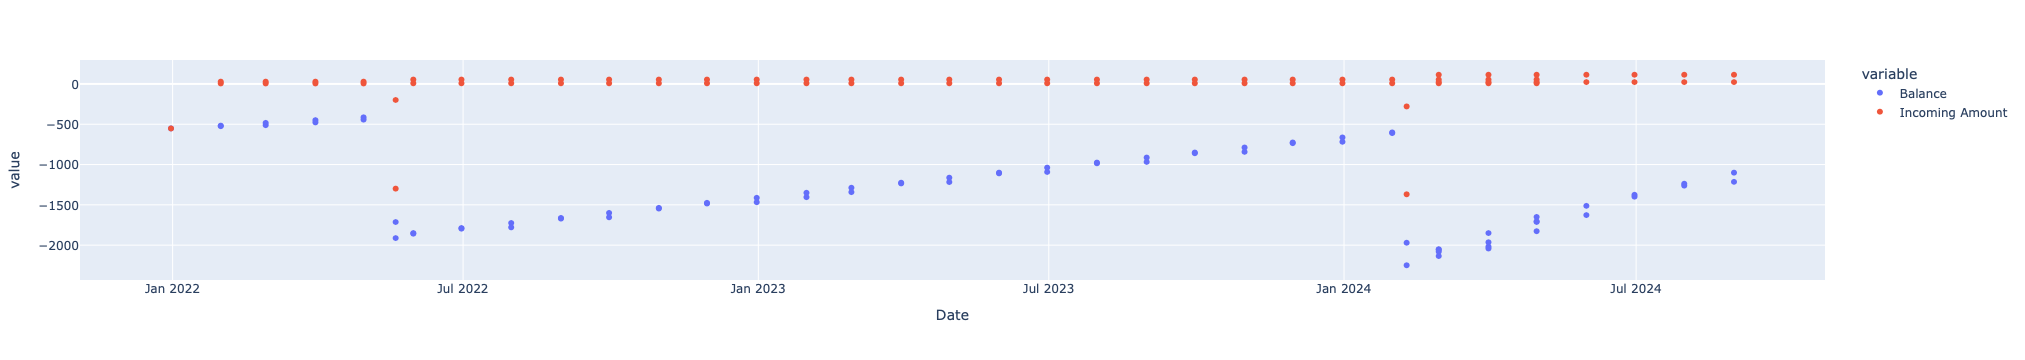

In [70]:
df = ledgers[ledgers["Subaccount"] == "Installments"]
fig = px.scatter(df, x="Date", y=["Balance", "Incoming Amount"])
fig.show()

In [71]:
apl=apl.sort_values("Transaction Date")
pd.set_option('display.max_rows', 200, 'display.max_columns', None)
ledgers[ledgers["Incoming Amount"] == 414.12]

Date                                        Description  \
765 2022-05-30  ACH DEPOSIT INTERNET TRANSFER FROM ACCOUNT END...   
785 2022-05-31                           APPLECARD GSBANK PAYMENT   

               Transaction Pair  Incoming Amount  \
765                    Transfer           414.12   
785  Assets:1st Source:Checking           414.12   

                    Account String         Type Account   Subaccount  Balance  \
765  Liabilities:Apple:Credit Card  Liabilities   Apple  Credit Card  -583.71   
785                       Transfer     Transfer                          0.00   

      Period  
765  2022-05  
785  2022-05

In [72]:
ledgers[ledgers["Incoming Amount"] == -414.12]

Date                                        Description  \
768 2022-05-30  ACH DEPOSIT INTERNET TRANSFER FROM ACCOUNT END...   
779 2022-05-31                           APPLECARD GSBANK PAYMENT   

                  Transaction Pair  Incoming Amount  \
768  Liabilities:Apple:Credit Card          -414.12   
779                       Transfer          -414.12   

                 Account String      Type     Account Subaccount  Balance  \
768                    Transfer  Transfer                         -414.12   
779  Assets:1st Source:Checking    Assets  1st Source   Checking 1,519.89   

      Period  
768  2022-05  
779  2022-05